In [1]:
from datetime import datetime

import xarray as xr
import numpy as np
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

In [2]:
# dask.config.set({'temporary_directory':'/Users/rwegener/repos/ch'})

client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58653,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58665,Total threads: 2
Dashboard: http://127.0.0.1:58668/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58656,


In [4]:
geopolar = xr.open_dataset('./data/SST_geopolar_chesapeake.nc')
geopolar = geopolar.analysed_sst

# TODO when downloading get just the smaller chunk
# TODO download the specific time chunk we want
geopolar = geopolar.sel(lat=slice(36.75, 40), lon=slice(-77.5, -75.5), time=slice('2003', '2021'))


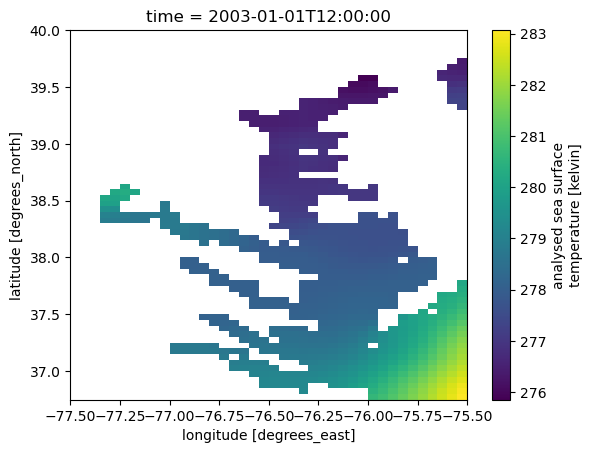

In [5]:
geopolar.isel(time=0).plot()

## Calculate Marine Heatwaves using `marineHeatWaves` Package

### Preprocessing

In [6]:
def format_time(time_np):
    # Format time values
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list])

In [7]:
time_ordinal = format_time(geopolar.time.values)
sst_np = geopolar.values

**TODO** this really shouldn't have to run twice.

In [8]:
data = da.from_array(sst_np, chunks=(-1, 25, 25))

In [ ]:
# define a wrapper to rearrange arguments
def func1d(arr, time):
    return mhw.detect(time, arr)

def block_func(block, **kwargs):
    return np.apply_along_axis(func1d, 0, block, **kwargs)

res = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
res = res.compute()

In [ ]:
_, clim = mhw.detect(time_ordinal, sst_np[:, 25, 25])

In [11]:
import dask.array as da
import numpy as np
import marineHeatWaves as mhw

# Create fake input data
# lat_size, long_size = 100, 100
# data = da.random.random_integers(0, 30, size=(1_000, long_size, lat_size), chunks=(-1, 10, 10))  # size = (time, longitude, latitude)
# time = np.arange(730_000, 731_000)  # time in ordinal days
time = time_ordinal

# define a wrapper to rearrange arguments
def func1d(arr, time):
    try:
         _, point_clim  = mhw.detect(time, arr)
    except:
        print('it was an error!')
        point_clim = {'thresh': [], 'seas': [], 'missing': [],}
    return point_clim

result = da.apply_along_axis(func1d, 0, data, time=time, dtype=data.dtype, shape=(1000,))
result.compute()


/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/marineHeatWaves-0.28-py3.11.egg/marineHeatWaves.py:406: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))


IndexError: tuple index out of range

In [ ]:
# Create fake input data
lat_size, long_size, time_size = len(geopolar.lat), len(geopolar.lon), len(geopolar.time)
data = da.from_array(sst_np, chunks=(-1, 25, 25))

# define a wrapper to rearrange arguments
def func1d_climatology(arr, time):
    try:
        _, point_clim = mhw.detect(time, arr)
    except:
        point_clim = {'thresh': [], 'seas': [], 'missing': [],}
    # return climatology
    return point_clim['seas']

# define a wrapper to rearrange arguments
# def func1d_threshold(arr, time):
#     _, point_clim = mhw.detect(time, arr)
#     # return threshold
#     return point_clim['thresh']

# output arrays
full_climatology = da.zeros_like(data)
# full_threshold = da.zeros_like(data)

climatology = da.apply_along_axis(func1d_climatology, 0, data, time=time_ordinal, 
                                  dtype=data.dtype, shape=(time_size,))
# threshold = da.apply_along_axis(func1d_threshold, 0, data, time=time, dtype=data.dtype,
#                                 shape=(time_size,))


In [ ]:
%%time

climatology = climatology.compute()

In [ ]:
%%time

threshold = threshold.compute()

## Calculate Average Stats by pixel

## Save into individual netcdf files